# FINALIZED

2025-11-09 14:23:44.264 | INFO     | __main__:<module>:37 - Loaded WhatsApp dataset: 4565 messages
2025-11-09 14:23:44.323 | INFO     | __main__:<module>:55 - 824 messages contain an exclamation mark
2025-11-09 14:23:44.328 | INFO     | __main__:<module>:63 - Aggregated text per author: 56 authors
2025-11-09 14:23:44.383 | INFO     | __main__:<module>:68 - Trigram feature matrix shape: (56, 6471)
2025-11-09 14:23:44.471 | INFO     | __main__:<module>:81 - Filtered authors with PCA1 > 60000; remaining: 55


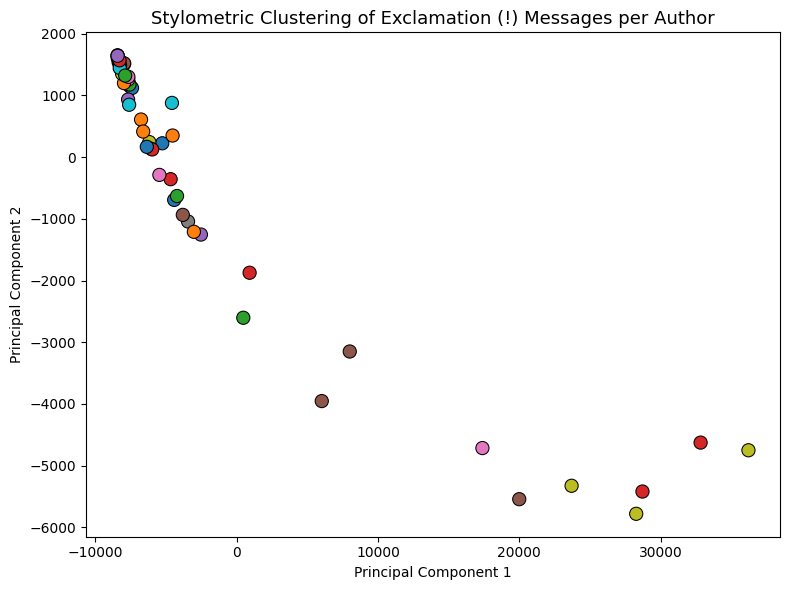

=== Authors in this cluster ===
               author             x            y
3      cackling-eland  28716.538513 -5419.230559
5       cheerful-mule  19995.750682 -5543.332942
18  flexible-platypus  28272.833321 -5780.106343
23       intense-toad  32831.481921 -4626.182306
38     radiant-coyote  23699.286429 -5325.884208
47        sudsy-eland  17388.656075 -4714.908170
49    sudsy-jellyfish  36217.862118 -4750.425981

Sample messages from authors in this region (n=10):

--- cackling-eland ---
• leuk! en gefeliciteerd. 🌷🌸🪻
• beste buren, goedenmorgen. er wordt bij 241 gewerkt vandaag en t/m zaterdag 5 april. lekage onderzoek door sop (bij badkamer/hal) en verbouwing. excuus voor het ongemaak! lift wordt beschermt en alles schoon gemaakt. er staat ook een container beneden een paar dagen. groet.
• beste buren, zoals eerder aangegeven is bij 241 verbouwing aan de gang. deze week wordt de vloer in een deel van de woning (slaapkamers) vervangen. volgende week even de badkamer afronden. d

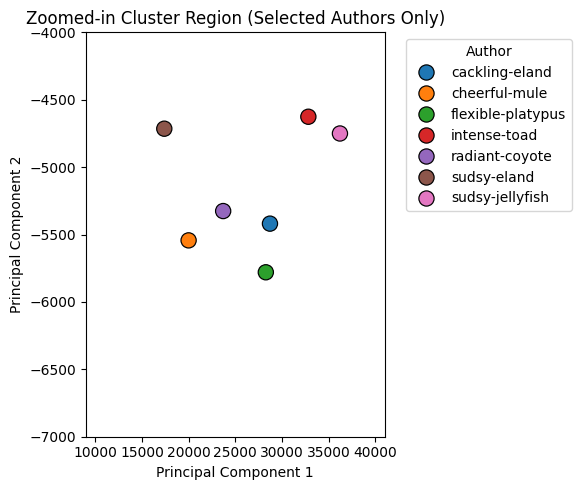


=== Cluster Summary ===
              author  total_exclamations  avg_length  emoji_ratio
0     cackling-eland                  51  120.156863     0.352941
1      cheerful-mule                  54   89.222222     0.129630
2  flexible-platypus                  91   65.670330     0.109890
3       intense-toad                  35  189.942857     0.285714
4     radiant-coyote                  57   97.333333     0.280702
5        sudsy-eland                  83   52.795181     0.060241
6    sudsy-jellyfish                  42  170.642857     0.023810


In [8]:
# %%
"""
Stylometric Analysis of WhatsApp Messages (exclamations Only)
----------------------------------------------------------
This script analyzes writing patterns of residents in an apartment group
using character trigram stylometry. It visualizes clusters of similar writing
styles and allows zooming into a specific PCA region to inspect the authors
and their messages.
"""

# %% Imports
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from loguru import logger
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

# %% Load dataset
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. Run src/preprocess.py first!")

wa_df_all = pd.read_parquet(datafile)
logger.info(f"Loaded WhatsApp dataset: {wa_df_all.shape[0]} messages")

# %% Clean text
def clean_message(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)  # remove links
    text = text.replace("\n", " ")
    text = re.sub(r"\s+", " ", text).strip()
    return text

wa_df_all["clean_text"] = wa_df_all["message"].apply(clean_message)
wa_df_all = wa_df_all[wa_df_all["clean_text"].str.len() > 0]

# %% Identify exclamation messages
wa_df_all["is_ exclamation"] = wa_df_all["clean_text"].str.contains(r"\!")

# %% Filter only exclamation messages
wa_q = wa_df_all[wa_df_all["is_ exclamation"]].copy()
logger.info(f"{wa_q.shape[0]} messages contain an exclamation mark")

# %% Group messages per author and concatenate text
author_texts = (
    wa_q.groupby("author")["clean_text"]
    .apply(lambda x: " ".join(x))
    .reset_index()
)
logger.info(f"Aggregated text per author: {author_texts.shape[0]} authors")

# %% Create trigram-based stylometric vectors
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
X = vectorizer.fit_transform(author_texts["clean_text"])
logger.info(f"Trigram feature matrix shape: {X.shape}")

# %% Compute pairwise Manhattan distances
distance = manhattan_distances(X, X)

# %% PCA for visualization
pca = PCA(n_components=2)
coords = pca.fit_transform(distance)
author_texts["x"] = coords[:, 0]
author_texts["y"] = coords[:, 1]

# Discard extreme PCA outliers (x > 60000)
author_texts = author_texts[author_texts["x"] <= 80000].copy()
logger.info(f"Filtered authors with PCA1 > 60000; remaining: {author_texts.shape[0]}")


# %% Scatterplot: all authors
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=author_texts,
    x="x",
    y="y",
    hue="author",
    palette="tab10",
    s=90,
    edgecolor="black",
)

plt.title("Stylometric Clustering of Exclamation (!) Messages per Author", fontsize=13)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend([], [], frameon=False)  # removes legend completely
plt.tight_layout()
plt.show()

# %% Function to inspect clusters
def inspect_cluster(df_authors, df_messages, xmin, xmax, ymin, ymax, sample_n=10):
    """
    Selects authors and messages from a PCA region.

    Parameters:
    - df_authors: DataFrame with ['author', 'x', 'y']
    - df_messages: Original exclamation-level DataFrame (wa_q)
    - xmin, xmax, ymin, ymax: coordinate range of cluster
    - sample_n: number of random messages to preview per author

    Returns:
    - cluster_authors_df: authors within coordinate range
    """
    cluster_authors_df = df_authors[
        (df_authors["x"] > xmin) & (df_authors["x"] < xmax)
        & (df_authors["y"] > ymin) & (df_authors["y"] < ymax)
    ].copy()

    if cluster_authors_df.empty:
        logger.warning("No authors found in this coordinate range.")
        return None

    print("=== Authors in this cluster ===")
    print(cluster_authors_df[["author", "x", "y"]])
    print("================================")

    selected_authors = cluster_authors_df["author"].tolist()
    subset = df_messages[df_messages["author"].isin(selected_authors)]

    print(f"\nSample messages from authors in this region (n={sample_n}):")
    for auth in selected_authors:
        print(f"\n--- {auth} ---")
        sample_msgs = subset[subset["author"] == auth]["clean_text"].sample(
            min(sample_n, len(subset[subset["author"] == auth])), random_state=42
        )
        for msg in sample_msgs:
            print(f"• {msg}")

    # Optional zoomed-in scatterplot
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=df_authors,
        x="x",
        y="y",
        hue="author",
        alpha=0.3,
        palette="tab10",
        s=80,
        legend=False,
    )
    sns.scatterplot(
        data=cluster_authors_df,
        x="x",
        y="y",
        hue="author",
        palette="tab10",
        s=120,
        edgecolor="black",
        legend=True,
    )
    plt.xlim(xmin - 1000, xmax + 1000)
    plt.ylim(ymin - 500, ymax + 500)
    plt.title("Zoomed-in Cluster Region (Selected Authors Only)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    return cluster_authors_df


# %% Example: Inspect and plot the encircled cluster
xmin, xmax, ymin, ymax = 10000, 40000, -6500, -4500
cluster_df = inspect_cluster(author_texts, wa_q, xmin, xmax, ymin, ymax)

# %% Save summary statistics for the cluster
if cluster_df is not None and not cluster_df.empty:
    selected_authors = cluster_df["author"].tolist()
    cluster_summary = (
        wa_q[wa_q["author"].isin(selected_authors)]
        .groupby("author")
        .agg(
            total_exclamations=("is_ exclamation", "sum"),
            avg_length=("message_length", "mean"),
            emoji_ratio=("has_emoji", "mean"),
        )
        .reset_index()
    )

    print("\n=== Cluster Summary ===")
    print(cluster_summary)
